# EDA and Base model


In [11]:
!pip install pathway --quiet


In [12]:
import pathway as pw
print("Schema found:", hasattr(pw, "Schema"))


Schema found: True


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
import pathway as pw
import bokeh.plotting
import panel as pn

# Step 1: Importing and Preprocessing the Data

In [85]:
df = pd.read_csv('dataset.csv')
df

# You can find the sample dataset here: https://drive.google.com/file/d/1D479FLjp9aO3Mg8g6Lpj9oRViWacurA6/view?usp=sharing

,ID,SystemCodeNumber,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime
0,0,BHMBCCMKT01,577,26.144536,91.736172,61,car,low,1,0,04-10-2016,07:59:00
1,1,BHMBCCMKT01,577,26.144536,91.736172,64,car,low,1,0,04-10-2016,08:25:00
2,2,BHMBCCMKT01,577,26.144536,91.736172,80,car,low,2,0,04-10-2016,08:59:00
3,3,BHMBCCMKT01,577,26.144536,91.736172,107,car,low,2,0,04-10-2016,09:32:00
4,4,BHMBCCMKT01,577,26.144536,91.736172,150,bike,low,2,0,04-10-2016,09:59:00
...,...,...,...,...,...,...,...,...,...,...,...,...
18363,18363,Shopping,1920,26.150504,91.733531,1517,truck,average,6,0,19-12-2016,14:30:00
18364,18364,Shopping,1920,26.150504,91.733531,1487,car,low,3,0,19-12-2016,15:03:00
18365,18365,Shopping,1920,26.150504,91.733531,1432,cycle,low,3,0,19-12-2016,15:29:00
18366,18366,Shopping,1920,26.150504,91.733531,1321,car,low,2,0,19-12-2016,16:03:00


In [86]:
# Combine the 'LastUpdatedDate' and 'LastUpdatedTime' columns into a single datetime column
df['Timestamp'] = pd.to_datetime(df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'],
                                  format='%d-%m-%Y %H:%M:%S')

# Sort the DataFrame by the new 'Timestamp' column and reset the index
df = df.sort_values('Timestamp').reset_index(drop=True)
df.QueueLength.unique()

array([ 1,  2,  3,  4,  5,  7,  6,  9,  8, 10, 11, 12, 13, 14,  0, 15])

In [87]:
# Save the selected columns to a CSV file for streaming or downstream processing
df[["Timestamp", "Occupancy", "Capacity"]].to_csv("parking_stream.csv", index=False)
# Note: Only three features are used here for simplicity.
# Participants are expected to incorporate additional relevant features in their models.

In [24]:
# Define the schema for the streaming data using Pathway
# This schema specifies the expected structure of each data row in the stream

class ParkingSchema(pw.Schema):
    Timestamp: str   # Timestamp of the observation (should ideally be in ISO format)
    Occupancy: int   # Number of occupied parking spots
    Capacity: int    # Total parking capacity at the location


In [33]:
# Load the data as a simulated stream using Pathway's replay_csv function
# This replays the CSV data at a controlled input rate to mimic real-time streaming
# input_rate=1000 means approximately 1000 rows per second will be ingested into the stream.

data = pw.demo.replay_csv("parking_stream.csv", schema=ParkingSchema, input_rate=1000)


In [34]:
# Define the datetime format to parse the 'Timestamp' column
fmt = "%Y-%m-%d %H:%M:%S"

# Add new columns to the data stream:
# - 't' contains the parsed full datetime
# - 'day' extracts the date part and resets the time to midnight (useful for day-level aggregations)
data_with_time = data.with_columns(
    t = data.Timestamp.dt.strptime(fmt),
    day = data.Timestamp.dt.strptime(fmt).dt.strftime("%Y-%m-%dT00:00:00")
)


In [158]:
d1 = pd.read_csv('dataset.csv')
d1['Timestamp'] = pd.to_datetime(d1['LastUpdatedDate'] + ' ' + d1['LastUpdatedTime'],
                                  format='%d-%m-%Y %H:%M:%S')

# Sort the DataFrame by the new 'Timestamp' column and reset the index
d1= d1.sort_values('Timestamp').reset_index(drop=True)
d1 = d1.drop(columns = ["LastUpdatedDate","LastUpdatedTime"])
d1['day_of_month'] = d1['Timestamp'].dt.day
d1['day_of_week'] = d1['Timestamp'].dt.dayofweek
d1["hour"] = d1.Timestamp.dt.hour
d1["minute"] = d1.Timestamp.dt.minute
d1["min_30"] = (d1["minute"] == 30).astype(int)
d1["min_59"] = (d1["minute"] == 59).astype(int)
traffic_map = {"low": 1, "average":2 ,"high": 3}
d1["TrafficConditionNearby"] = d1["TrafficConditionNearby"].map(traffic_map)


d1 = d1.drop([ 'Latitude', 'Longitude'], axis=1)
d1['Fraction_Occupied'] = d1['Occupancy'] / d1['Capacity']
d1 = d1.drop(['ID'], axis=1)
d1

,SystemCodeNumber,Capacity,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,Timestamp,day_of_month,day_of_week,hour,minute,min_30,min_59,Fraction_Occupied
0,BHMBCCMKT01,577,61,car,1,1,0,2016-10-04 07:59:00,4,1,7,59,0,1,0.105719
1,BHMNCPHST01,1200,237,bike,1,2,0,2016-10-04 07:59:00,4,1,7,59,0,1,0.197500
2,BHMMBMMBX01,687,264,car,1,2,0,2016-10-04 07:59:00,4,1,7,59,0,1,0.384279
3,BHMNCPNST01,485,249,car,1,2,0,2016-10-04 07:59:00,4,1,7,59,0,1,0.513402
4,Shopping,1920,614,cycle,1,2,0,2016-10-04 07:59:00,4,1,7,59,0,1,0.319792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18363,BHMEURBRD01,470,373,car,1,2,0,2016-12-19 16:30:00,19,0,16,30,1,0,0.793617
18364,BHMBCCTHL01,387,387,car,1,2,0,2016-12-19 16:30:00,19,0,16,30,1,0,1.000000
18365,BHMBCCMKT01,577,193,cycle,1,2,0,2016-12-19 16:30:00,19,0,16,30,1,0,0.334489
18366,Others-CCCPS98,3103,1671,car,1,3,0,2016-12-19 16:30:00,19,0,16,30,1,0,0.538511


In [159]:
import altair as alt

# Calculate the average occupancy rate per day of the week for each vehicle type
occupancy_by_day_vehicle = d1.groupby(['day_of_week', 'VehicleType'])['Fraction_Occupied'].mean().reset_index()

# Create a line chart with day_of_week on the x-axis and Fraction_Occupied on the y-axis, colored by VehicleType
chart = alt.Chart(occupancy_by_day_vehicle).mark_line().encode(
    x='day_of_week:O',  # Ordinal scale for day of week
    y='Fraction_Occupied:Q',  # Quantitative scale for occupancy rate
    color='VehicleType:N'  # Nominal scale for Vehicle Type
).properties(
    title='Average Occupancy Rate by Day of Week and Vehicle Type'
)

chart

alt.Chart(...)

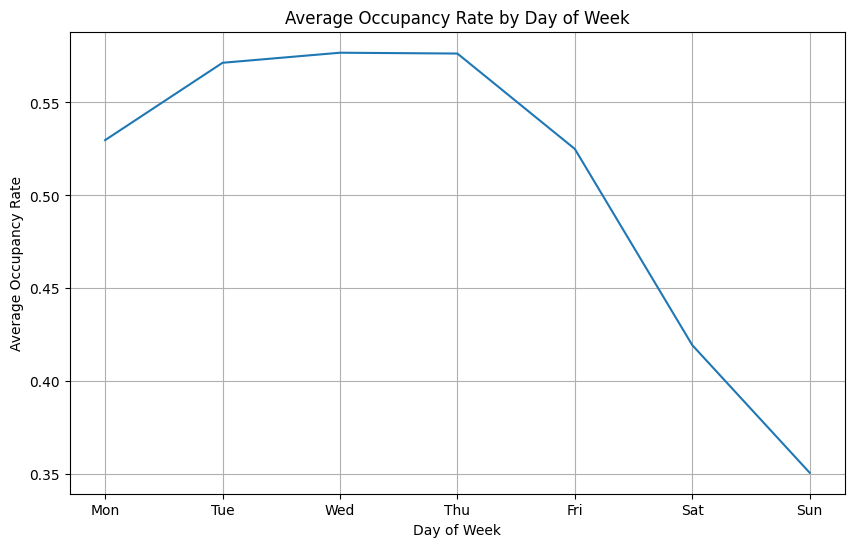

In [154]:

import matplotlib.pyplot as plt
# Group by day of the week and calculate the mean of the occupancy rate
grouped_data = d1.groupby('day_of_week')['Fraction_Occupied'].mean()
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(grouped_data.index, grouped_data.values)
plt.xlabel('Day of Week')
plt.ylabel('Average Occupancy Rate')
plt.title('Average Occupancy Rate by Day of Week')
plt.xticks(grouped_data.index, ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']) # Set x-axis labels
plt.grid(True)
plt.show()

# Step 2: Making a simple pricing function

In [ ]:
# Define a daily tumbling window over the data stream using Pathway
# This block performs temporal aggregation and computes a dynamic price for each day
import datetime

delta_window = (
    data_with_time.windowby(
        pw.this.t,  # Event time column to use for windowing (parsed datetime)
        instance=pw.this.day,  # Logical partitioning key: one instance per calendar day
        window=pw.temporal.tumbling(datetime.timedelta(days=1)),  # Fixed-size daily window
        behavior=pw.temporal.exactly_once_behavior()  # Guarantees exactly-once processing semantics
    )
    .reduce(
        t=pw.this._pw_window_end,                        # Assign the end timestamp of each window
        occ_max=pw.reducers.max(pw.this.Occupancy),      # Highest occupancy observed in the window
        occ_min=pw.reducers.min(pw.this.Occupancy),      # Lowest occupancy observed in the window
        cap=pw.reducers.max(pw.this.Capacity),           # Maximum capacity observed (typically constant per spot)
    )
    .with_columns(
        # Compute the price using a simple dynamic pricing formula:
        #
        # Pricing Formula:
        #     price = base_price + demand_fluctuation
        #     where:
        #         base_price = 10 (fixed minimum price)
        #         demand_fluctuation = (occ_max - occ_min) / cap
        #
        # Intuition:
        # - The greater the difference between peak and low occupancy in a day,
        #   the more volatile the demand is, indicating potential scarcity.
        # - Dividing by capacity normalizes the fluctuation (to stay in [0,1] range).
        # - This fluctuation is added to the base price of 10 to set the final price.
        # - Example: If occ_max = 90, occ_min = 30, cap = 100
        #            => price = 10 + (90 - 30)/100 = 10 + 0.6 = 10.6

        price=10 + (pw.this.occ_max - pw.this.occ_min) / pw.this.cap
    )
)


# Step 3: Visualizing Daily Price Fluctuations with a Bokeh Plot

**Note:** The Bokeh plot in the next cell will only be generated after you run the `pw.run()` cell (i.e., the final cell).


In [ ]:
# Activate the Panel extension to enable interactive visualizations
pn.extension()

# Define a custom Bokeh plotting function that takes a data source (from Pathway) and returns a figure
def price_plotter(source):
    # Create a Bokeh figure with datetime x-axis
    fig = bokeh.plotting.figure(
        height=400,
        width=800,
        title="Pathway: Daily Parking Price",
        x_axis_type="datetime",  # Ensure time-based data is properly formatted on the x-axis
    )
    # Plot a line graph showing how the price evolves over time
    fig.line("t", "price", source=source, line_width=2, color="navy")

    # Overlay red circles at each data point for better visibility
    fig.circle("t", "price", source=source, size=6, color="red")

    return fig

# Use Pathway's built-in .plot() method to bind the data stream (delta_window) to the Bokeh plot
# - 'price_plotter' is the rendering function
# - 'sorting_col="t"' ensures the data is plotted in time order
viz = delta_window.plot(price_plotter, sorting_col="t")

# Create a Panel layout and make it servable as a web app
# This line enables the interactive plot to be displayed when the app is served
pn.Column(viz).servable()

In [ ]:
# Start the Pathway pipeline execution in the background
# - This triggers the real-time data stream processing defined above
# - %%capture --no-display suppresses output in the notebook interface

%%capture --no-display
pw.run()